# Dependências 

In [200]:
import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib.pyplot as plt
from glob import glob
from os.path import basename
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.models import Sequential

pd.options.display.max_columns = None
%matplotlib inline

In [201]:
COLS_SCOUTS_DEF = ['CA','CV', 'DE', 'DP','DS','FC','GC','GS','SG', 'PP', 'PC'] # alphabetical order
COLS_SCOUTS_ATK = ['A','FD','FF','FS','FT','G','I','PS'] # alphabetical order
COLS_SCOUTS = COLS_SCOUTS_DEF + COLS_SCOUTS_ATK
SCOUTS_POINTS = np.array([-1 , -3, 1, 7, 1.2, -0.3, -3, -1, 5, -4, -1,
                          5, 1.2, 0.8, 0.5, 3, 8, -0.1, 1])

COLS_STATISTICS = ['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num', 'atletas.media_num']
COLS_ATHLETES_INFO = ['atletas.atleta_id', 'atletas.apelido', 'atletas.posicao_id', 'atletas.clube.id.full.name', 'atletas.status_id']

COL_ID = 'atletas.atleta_id'
COL_ROUND = 'atletas.rodada_id'
COL_POINTS = 'atletas.pontos_num'
COL_POSITION = 'atletas.posicao_id'
COL_STATUS = 'atletas.status_id'
COL_TEAM_ID = 'atletas.clube.id.full.name'
COL_NICKNAME = 'atletas.apelido'

COLS_ALL = [COL_ROUND] + COLS_ATHLETES_INFO + COLS_STATISTICS + COLS_SCOUTS

In [202]:
COLS_ALL

['atletas.rodada_id',
 'atletas.atleta_id',
 'atletas.apelido',
 'atletas.posicao_id',
 'atletas.clube.id.full.name',
 'atletas.status_id',
 'atletas.pontos_num',
 'atletas.preco_num',
 'atletas.variacao_num',
 'atletas.media_num',
 'CA',
 'CV',
 'DE',
 'DP',
 'DS',
 'FC',
 'GC',
 'GS',
 'SG',
 'PP',
 'PC',
 'A',
 'FD',
 'FF',
 'FS',
 'FT',
 'G',
 'I',
 'PS']

In [203]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.hdf5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return '{}{}{}{}'.format(prefix, timestamp, suffix, ext)

# Importação dos Dados

In [204]:
import glob

In [205]:
diretc = 'D:/Projetos/Python/caRtola/data/01_raw/2023/'
file = 'rodada-*.csv'
nomes_arquivos = glob.glob(diretc + file)

In [206]:
dfs = []
for i in nomes_arquivos:
    df = pd.read_csv(i)
    dfs.append(df)

In [207]:
df = pd.concat(dfs, ignore_index=True)

In [208]:
df.isnull().sum()

Unnamed: 0                          0
atletas.temporada_id             5027
atletas.clube.id.full.name          0
atletas.slug                        0
atletas.apelido_abreviado           0
atletas.status_id                   0
atletas.rodada_id                   0
atletas.variacao_num                0
atletas.nome                        0
atletas.jogos_num                   0
atletas.clube_id                    0
atletas.pontos_num                  0
atletas.foto                       25
atletas.minimo_para_valorizar    2845
atletas.posicao_id                  0
atletas.preco_num                   0
atletas.media_num                   0
atletas.atleta_id                   0
atletas.apelido                     0
DS                               3068
FC                               3020
FD                               4361
FS                               3140
G                                5041
SG                               5079
FF                               3948
CA          

# Limpeza dos Dados 

In [209]:
df = df.drop(['atletas.temporada_id', 'atletas.minimo_para_valorizar', 'atletas.foto', 'Unnamed: 0', 'V'], axis=1)

In [210]:
def decumulate_scouts(df):
    list_ids = list(df[COL_ID].unique())
    n_players = len(list_ids)

    df_copy = df.copy()
    for i, player_id in enumerate(list_ids):
        print('{} of {}'.format(i + 1, n_players), end='\r')

        df_player = df[df[COL_ID] == player_id].sort_values(by=COL_ROUND)
        df_shift = df_player.shift(fill_value=0.0)
        df_player[COLS_SCOUTS] = df_player[COLS_SCOUTS] - df_shift[COLS_SCOUTS]

        df_copy.loc[df_player.index] = df_player

    return df_copy

def check_scouts_pontuation(df):
    df_copy = df.copy()
    df_copy['computed'] = df_copy.apply(lambda row: np.round(sum(row[COLS_SCOUTS] * SCOUTS_POINTS), decimals=2), axis=1)
    mask_diff = df_copy[COL_POINTS] != df_copy['computed']
    display(df_copy[mask_diff])

In [211]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=COLS_SCOUTS)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove técnicos
df_clean = df_clean[df_clean[COL_POSITION] != "tec"]
print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# altera os Status == 'Nulo' para 'Provável'
df_clean.loc[df_clean[COL_STATUS] == 'Nulo', COL_STATUS] = 'Provável'

# preenche scouts NANs com zero
df_clean[COLS_SCOUTS] = df_clean[COLS_SCOUTS].fillna(value=0)

# desacumula os valores de scouts
df_clean = decumulate_scouts(df_clean)

# checa se...
#assert(~df_clean.isnull().any().any()) # ainda existem valores nulos
#assert((df_clean[COLS_SCOUTS].min() >= 0.0).all()) # há scouts negativos

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)
df_clean.describe()

Dimensões originais dos dados:  (5730, 34)
qtde. de jogadores com scouts:  3414
qtde. de linhas com posições válidas:  3414
Dimensão dos dados após as limpezas:  (3414, 34)


,atletas.rodada_id,atletas.variacao_num,atletas.jogos_num,atletas.clube_id,atletas.pontos_num,atletas.posicao_id,atletas.preco_num,atletas.media_num,atletas.atleta_id,DS,FC,FD,FS,G,SG,FF,CA,I,DE,GS,DP,A,FT,PC,PS,PP,CV,GC
count,3414.000000,3414.00000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000
mean,4.934095,0.00937,3.277973,333.405682,2.159813,3.630639,6.073260,3.243325,92780.807264,0.772115,0.684534,0.160223,0.649678,0.061219,0.069420,0.257176,0.129467,0.088459,0.161101,0.062390,0.000586,0.043351,0.015524,0.005858,0.004687,0.001465,0.005858,0.001172
std,2.086903,1.17876,1.966106,228.136819,3.450156,1.204693,3.520358,2.637280,18566.978698,1.223932,1.044181,0.450724,1.091884,0.255158,0.254204,0.594486,0.335765,0.335114,0.880061,0.366208,0.024200,0.213508,0.128296,0.076326,0.068308,0.038247,0.076326,0.034214
min,2.000000,-7.19000,0.000000,262.000000,-4.200000,1.000000,0.650000,-3.000000,37656.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,-0.47000,2.000000,267.000000,0.000000,3.000000,3.470000,1.270000,82455.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.00000,3.000000,280.000000,0.500000,4.000000,5.330000,2.800000,94514.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.23000,5.000000,293.000000,3.200000,5.000000,8.007500,4.777500,106639.500000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.77000,8.000000,1371.000000,27.600000,5.000000,23.820000,20.800000,124834.000000,9.000000,7.000000,5.000000,8.000000,2.000000,1.000000,5.000000,1.000000,4.000000,13.000000,5.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [212]:

df_clean.isnull().sum().sort_values(ascending=False)

atletas.clube.id.full.name    0
GS                            0
G                             0
SG                            0
FF                            0
CA                            0
I                             0
DE                            0
DP                            0
atletas.slug                  0
A                             0
FT                            0
PC                            0
PS                            0
PP                            0
CV                            0
FS                            0
FD                            0
FC                            0
DS                            0
atletas.apelido               0
atletas.atleta_id             0
atletas.media_num             0
atletas.preco_num             0
atletas.posicao_id            0
atletas.pontos_num            0
atletas.clube_id              0
atletas.jogos_num             0
atletas.nome                  0
atletas.variacao_num          0
atletas.rodada_id             0
atletas.

In [213]:
check_scouts_pontuation(df_clean)

,atletas.clube.id.full.name,atletas.slug,atletas.apelido_abreviado,atletas.status_id,atletas.rodada_id,atletas.variacao_num,atletas.nome,atletas.jogos_num,atletas.clube_id,atletas.pontos_num,atletas.posicao_id,atletas.preco_num,atletas.media_num,atletas.atleta_id,atletas.apelido,DS,FC,FD,FS,G,SG,FF,CA,I,DE,GS,DP,A,FT,PC,PS,PP,CV,GC,computed
1,Fluminense,fabio,FÃ¡bio,7,2,-0.10,FÃ¡bio Deivson Lopes Maciel,1,266,0.0,1,12.90,7.0,37656,FÃ¡bio,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,Santos,bruno-mezenga,B. Mezenga,6,2,-0.65,Bruno Ferreira Mombra Rosa,1,277,0.0,5,3.35,1.2,37865,Bruno Mezenga,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
3,SÃ£o Paulo,rafinha,Rafinha,7,2,0.06,MÃ¡rcio Rafael Ferreira de Souza,1,276,0.0,2,6.06,3.4,38144,Rafinha,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4
5,AmÃ©rica-MG,wellington-paulista,W. Paulista,2,2,-0.26,Wellington Pereira do Nascimento,1,327,0.0,5,5.74,2.9,38279,Wellington Paulista,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.9
6,AthlÃ©tico-PR,thiago-heleno,T. Heleno,7,2,0.36,Thiago Heleno Henrique Ferreira,1,293,0.0,3,7.36,4.4,38394,Thiago Heleno,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,Bahia,cauly,Cauly,7,2,-0.48,Cauly Oliveira Souza,1,265,0.0,4,4.52,2.0,123360,Cauly,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
691,Palmeiras,luis-guilherme,L. Guilherme,6,2,0.68,Luis Guilherme Lira dos Santos,1,275,0.0,4,1.68,1.6,123713,Luis Guilherme,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6
695,Bragantino,henry-mosquera,H. Mosquera,7,2,2.87,Henry David Mosquera SÃ¡nchez,1,280,0.0,5,3.87,5.0,124239,Henry Mosquera,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
696,AtlÃ©tico-MG,isaac,Isaac,6,2,-0.90,Isaac Aguiar Tomich,1,282,0.0,5,1.10,-0.3,124247,Isaac,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.3


[2 3 4 5 6 7 8] [654 399 430 463 475 489 504]


<BarContainer object of 7 artists>

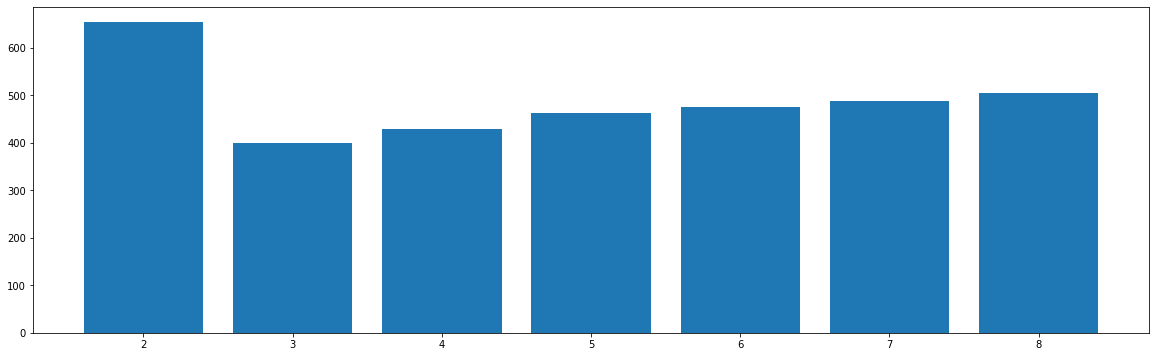

In [214]:
unique, counts = np.unique(df_clean[COL_ROUND].values, return_counts=True)
print(unique, counts)

plt.figure(figsize=(20, 6))
plt.bar(unique, counts)

In [215]:
#pandas_profiling.ProfileReport(df_clean)

# Criação das Amostras

In [216]:
def create_samples(df, cols_of_interest, from_round=1, to_round=None, last_rounds=None, return_pred=True):
    players = list(df[COL_ID].unique())
    rounds = list(df[COL_ROUND].unique())
    n_rounds = max(rounds)
    n_players = len(players)
    to_round = n_rounds if to_round is None else to_round
    last_rounds = n_rounds - 1 if last_rounds is None else last_rounds
    
    list_rounds = np.array([list(range(1, n_rounds+1))  for _ in range(n_players)]).flatten()
    list_players = np.array([[player] * n_rounds for player in players]).flatten()
    df_all = pd.DataFrame([[p, r] for p, r in zip(list_players, list_rounds)], columns=[COL_ID, COL_ROUND])
    
    df_merge = df_all.merge(df, how='left', on=[COL_ID, COL_ROUND])
    df_merge.fillna(value=0, inplace=True)
    
    x, y = [], []
    for r in range(from_round, to_round - last_rounds + 1):
        print('x: rodadas de {:}-{:} y: rodada {}'.format(r, r + last_rounds - 1, r + last_rounds))
        
        df_round = df_merge[(df_merge[COL_ROUND] >= r) & (df_merge[COL_ROUND] < r + last_rounds)]
        df_group = df_round.groupby(by=[COL_ID], as_index=False, sort=False)
        x.append([data[cols_of_interest].values for _, data in df_group])
            
        df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
        if return_pred:
            df_next = df_merge[df_merge[COL_ROUND] == r + last_rounds]
            #assert(np.all(df_ids[COL_ID].values ==  df_next[COL_ID].values))

            df_points = df_ids.merge(df_next, how='left', on=[COL_ID])[COL_POINTS]
            y.append(df_points.fillna(value=0).values)
        
    return np.concatenate([r for r in x]), np.array(y).flatten() if return_pred else df_ids[COL_ID].values

In [217]:
df_samples = pd.get_dummies(df_clean, columns=[COL_POSITION, COL_TEAM_ID], prefix=['pos', 'clube'])
print(df_samples.shape)
df_samples.head()

(3414, 64)


,atletas.slug,atletas.apelido_abreviado,atletas.status_id,atletas.rodada_id,atletas.variacao_num,atletas.nome,atletas.jogos_num,atletas.clube_id,atletas.pontos_num,atletas.preco_num,atletas.media_num,atletas.atleta_id,atletas.apelido,DS,FC,FD,FS,G,SG,FF,CA,I,DE,GS,DP,A,FT,PC,PS,PP,CV,GC,pos_1,pos_2,pos_3,pos_4,pos_5,clube_AmÃ©rica-MG,clube_América-MG,clube_AthlÃ©tico-PR,clube_Athlético-PR,clube_AtlÃ©tico-MG,clube_Atlético-MG,clube_Bahia,clube_Botafogo,clube_Bragantino,clube_Corinthians,clube_Coritiba,clube_Cruzeiro,clube_CuiabÃ¡,clube_Cuiabá,clube_Flamengo,clube_Fluminense,clube_Fortaleza,clube_GoiÃ¡s,clube_Goiás,clube_GrÃªmio,clube_Grêmio,clube_Internacional,clube_Palmeiras,clube_Santos,clube_SÃ£o Paulo,clube_São Paulo,clube_Vasco
1,fabio,FÃ¡bio,7,2,-0.10,FÃ¡bio Deivson Lopes Maciel,1,266,0.0,12.90,7.0,37656,FÃ¡bio,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,bruno-mezenga,B. Mezenga,6,2,-0.65,Bruno Ferreira Mombra Rosa,1,277,0.0,3.35,1.2,37865,Bruno Mezenga,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,rafinha,Rafinha,7,2,0.06,MÃ¡rcio Rafael Ferreira de Souza,1,276,0.0,6.06,3.4,38144,Rafinha,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,wellington-paulista,W. Paulista,2,2,-0.26,Wellington Pereira do Nascimento,1,327,0.0,5.74,2.9,38279,Wellington Paulista,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,thiago-heleno,T. Heleno,7,2,0.36,Thiago Heleno Henrique Ferreira,1,293,0.0,7.36,4.4,38394,Thiago Heleno,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [218]:
cols_of_interest = df_samples.columns.drop([COL_ROUND, COL_ID, COL_NICKNAME, COL_STATUS])
cols_of_interest

Index(['atletas.slug', 'atletas.apelido_abreviado', 'atletas.variacao_num',
       'atletas.nome', 'atletas.jogos_num', 'atletas.clube_id',
       'atletas.pontos_num', 'atletas.preco_num', 'atletas.media_num', 'DS',
       'FC', 'FD', 'FS', 'G', 'SG', 'FF', 'CA', 'I', 'DE', 'GS', 'DP', 'A',
       'FT', 'PC', 'PS', 'PP', 'CV', 'GC', 'pos_1', 'pos_2', 'pos_3', 'pos_4',
       'pos_5', 'clube_AmÃ©rica-MG', 'clube_América-MG', 'clube_AthlÃ©tico-PR',
       'clube_Athlético-PR', 'clube_AtlÃ©tico-MG', 'clube_Atlético-MG',
       'clube_Bahia', 'clube_Botafogo', 'clube_Bragantino',
       'clube_Corinthians', 'clube_Coritiba', 'clube_Cruzeiro',
       'clube_CuiabÃ¡', 'clube_Cuiabá', 'clube_Flamengo', 'clube_Fluminense',
       'clube_Fortaleza', 'clube_GoiÃ¡s', 'clube_Goiás', 'clube_GrÃªmio',
       'clube_Grêmio', 'clube_Internacional', 'clube_Palmeiras',
       'clube_Santos', 'clube_SÃ£o Paulo', 'clube_São Paulo', 'clube_Vasco'],
      dtype='object')

In [220]:
x, y = create_samples(df_samples, cols_of_interest, from_round=1, to_round=9, last_rounds=5)

print(x.shape, y.shape)

x: rodadas de 1-5 y: rodada 6


C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  x.append([data[cols_of_interest].values for _, data in df_group])
C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:24: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to

x: rodadas de 2-6 y: rodada 7


C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:24: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  x.append([data[cols_of_interest].values for _, data in df_group])


x: rodadas de 3-7 y: rodada 8


C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:24: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  x.append([data[cols_of_interest].values for _, data in df_group])


x: rodadas de 4-8 y: rodada 9


C:\Users\Jhona\AppData\Local\Temp/ipykernel_22224/1540184304.py:24: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 3 dimension(s)

# Treinamento do Modelo

In [ ]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=x.shape[1:]))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

FILE_MODEL = 'models/' + timestamp_model_name()
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, verbose=1, save_best_only=True),
    EarlyStopping(verbose=1, patience=20)
]

hist = model.fit(x, y, batch_size=32, epochs=200, validation_split=0.2, callbacks=list_callbacks)

NameError: name 'x' is not defined

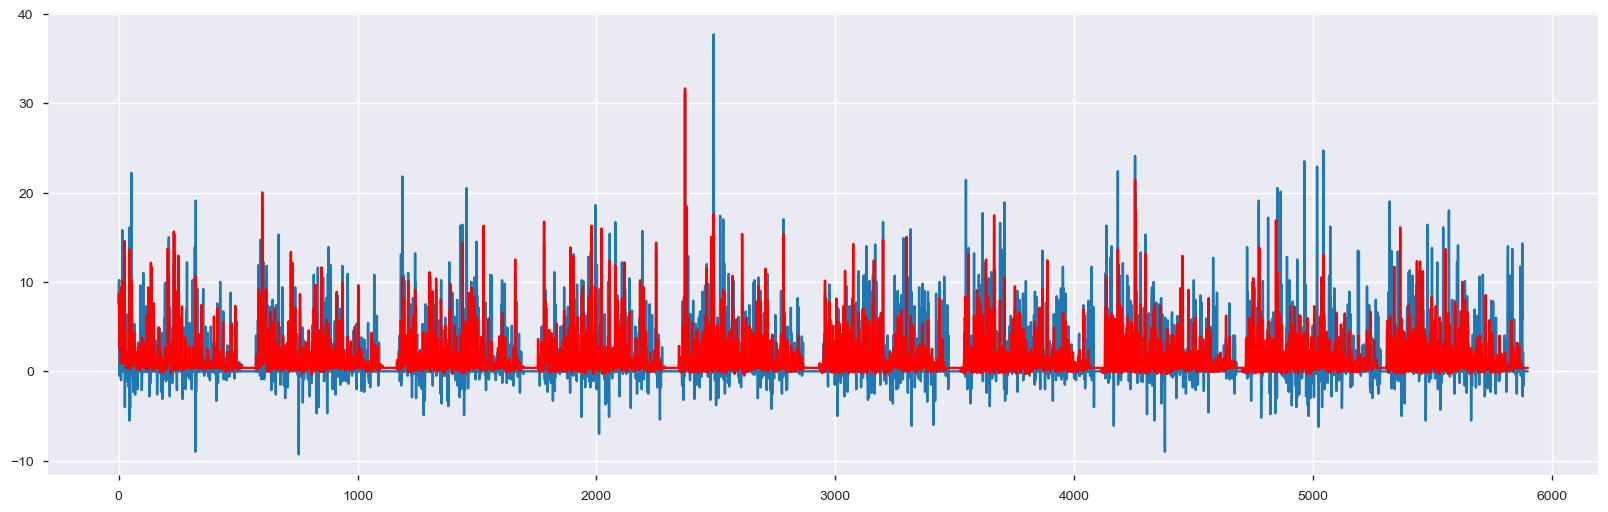

In [ ]:
y_pred = model.predict(x)

plt.figure(figsize=(20, 6))
plt.plot(y)
plt.plot(y_pred, color='red')

# Predição de Jogadores

In [ ]:
x_test, ids = create_samples(df_samples, cols_of_interest, from_round=2, to_round=5, last_rounds=3, return_pred=False)

print(x_test.shape, ids.shape)

In [ ]:
y_next = model.predict(x_test)
sort_pos = np.argsort(y_next.flatten())
best_ids = ids[sort_pos[-10:]]

print(best_ids)

In [ ]:
assert(np.all(df_samples[COL_ID].values == df_clean[COL_ID].values))

df_pred = df_clean[df_clean[COL_ID].isin(best_ids)].drop_duplicates(subset=COL_ID)
df_pred

In [ ]:
y_next[sort_pos[-10:]]